<a href="https://colab.research.google.com/github/AnujM09/Email_Spam_Classifier/blob/main/Email_Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

from wordcloud import WordCloud
from collections import Counter

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
spam = pd.read_csv('/content/drive/MyDrive/Capstone_Project_For_Data_Science/Email Spam Classifier/spam.csv', encoding = 'latin-1')

In [4]:
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
spam.shape

(5572, 5)

Data Cleaning 
EDA
Text Preprocessing
Model Building 
Evaluation
Improvements
Website Conversion
Deploy on Heroku



## **1. Data Cleaning**

In [6]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
spam.drop(columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace = True)

In [8]:
spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
spam.rename(columns = {'v1':'target', 'v2': 'text'}, inplace = True)

In [10]:
# From LabelEncoder 
encoder = LabelEncoder()

In [11]:
spam['target'] = encoder.fit_transform(spam['target'])

In [12]:
spam.isnull().sum()

target    0
text      0
dtype: int64

In [13]:
spam.duplicated().sum()

403

In [14]:
spam = spam.drop_duplicates(keep = 'first')

In [15]:
spam.duplicated().sum()

0

In [16]:
spam.shape

(5169, 2)

## **2. EDA**

In [17]:
 spam.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
spam.value_counts(spam['target'])

target
0    4516
1     653
dtype: int64

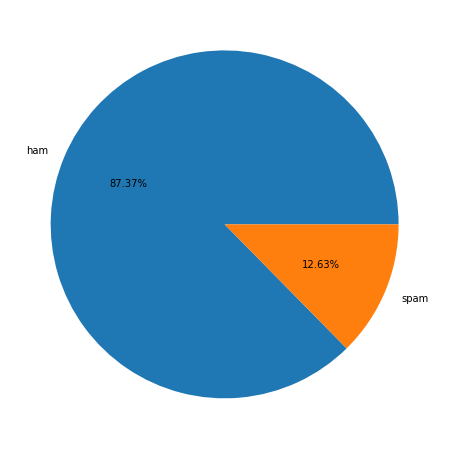

In [19]:
plt.figure(figsize = (8,8))
plt.pie(spam['target'].value_counts(), labels = ['ham','spam'], autopct = "%0.2f%%")
plt.show()

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
spam['num_char'] = spam['text'].apply(len)

In [22]:
spam['num_words'] = spam['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [23]:
spam.head()

,target,text,num_char,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [24]:
spam['num_sentences'] = spam['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [25]:
spam[['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [26]:
spam[spam['target'] == 1][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


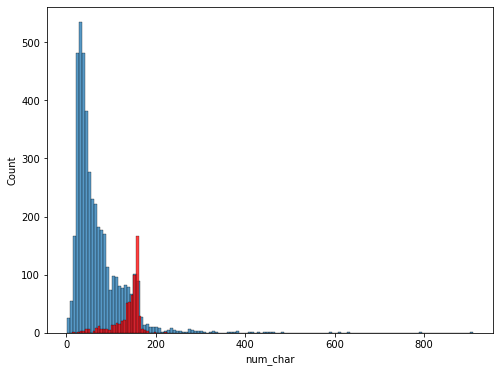

In [27]:
plt.figure(figsize = (8,6))
sns.histplot(spam[spam['target'] == 0]['num_char'])
sns.histplot(spam[spam['target'] == 1]['num_char'], color = 'red')
plt.show()

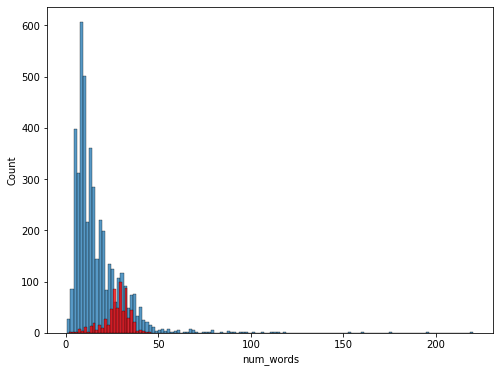

In [28]:
plt.figure(figsize = (8,6))
sns.histplot(spam[spam['target'] == 0]['num_words'])
sns.histplot(spam[spam['target'] == 1]['num_words'], color = 'red')
plt.show()

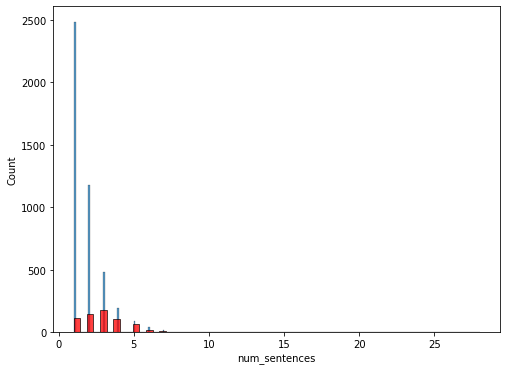

In [29]:
plt.figure(figsize = (8,6))
sns.histplot(spam[spam['target'] == 0]['num_sentences'])
sns.histplot(spam[spam['target'] == 1]['num_sentences'], color = 'red')
plt.show()

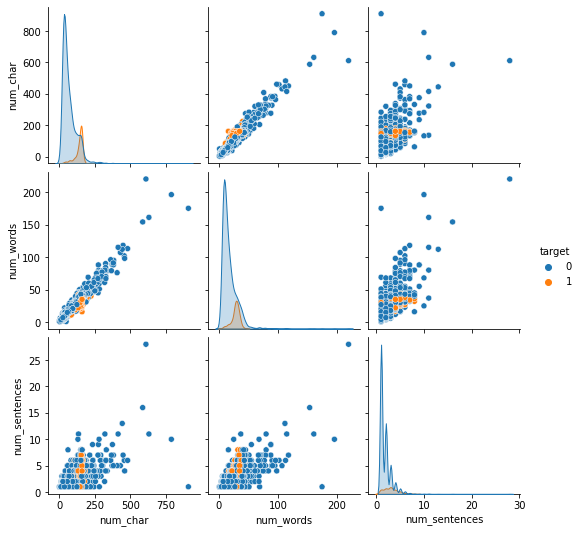

In [30]:
sns.pairplot(spam, hue = 'target')

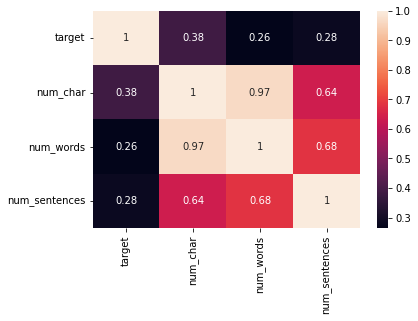

In [31]:
sns.heatmap(spam.corr(), annot = True)

## 3. Data Preprocessing

In [32]:
def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)

  y = []
  for i in text:
    if i.isalnum():
      y.append(i)

  text = y[:]
  y.clear()

  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)
  
  text = y[:]
  y.clear()

  for i in text:
    y.append(ps.stem(i))

  return " ".join(y)

In [33]:
spam['Trans_text'] = spam['text'].apply(transform_text) 

In [34]:
spam.head()

,target,text,num_char,num_words,num_sentences,Trans_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [35]:
# From WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(spam[spam['target'] == 1]['Trans_text'].str.cat(sep = " "))

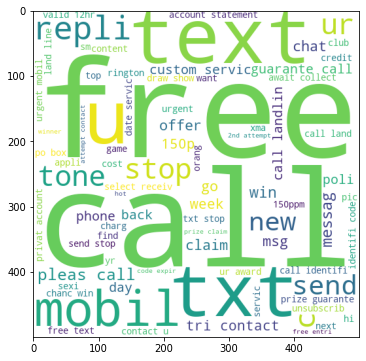

In [36]:
plt.figure(figsize = (12,6))
plt.imshow(spam_wc)

In [37]:
ham_wc = wc.generate(spam[spam['target'] == 0]['Trans_text'].str.cat(sep = " "))

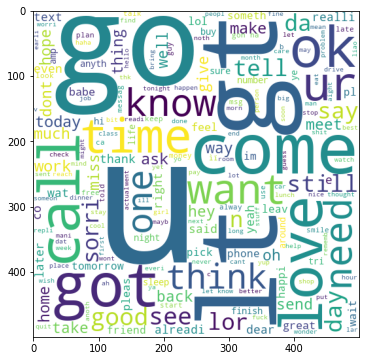

In [38]:
plt.figure(figsize = (12,6))
plt.imshow(ham_wc)

In [39]:
spam.head()

,target,text,num_char,num_words,num_sentences,Trans_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [40]:
spam_corpus = []
for msg in spam[spam['target'] == 1]['Trans_text'].tolist():
  for word in msg.split():
    spam_corpus.append(word)

In [41]:
len(spam_corpus)

9939

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

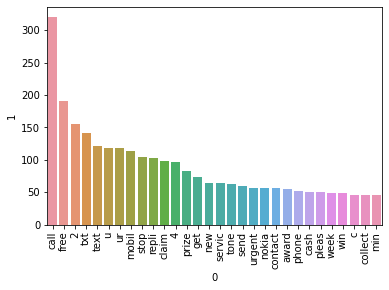

In [42]:
# from Collections library
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')

In [43]:
ham_corpus = []
for msg in spam[spam['target'] == 0]['Trans_text'].tolist():
  for word in msg.split():
    ham_corpus.append(word)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

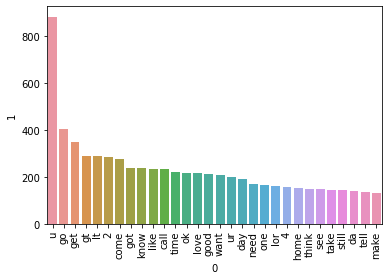

In [44]:
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')

## **4. Model Building**

In [45]:
spam.head()

,target,text,num_char,num_words,num_sentences,Trans_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [46]:
# From CountVectorizer
cv = CountVectorizer()

In [47]:
X = cv.fit_transform(spam['Trans_text']).toarray()

In [48]:
X.shape

(5169, 6708)

In [49]:
y = spam['target'].values

In [50]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [52]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [53]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8800773694390716
[[792 104]
 [ 20 118]]
0.5315315315315315


In [54]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9642166344294004
[[871  25]
 [ 12 126]]
0.8344370860927153


In [55]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283


In [56]:
# From TfidVectorizer
tfidf = TfidfVectorizer(max_features = 3000)

In [57]:
X = tfidf.fit_transform(spam['Trans_text']).toarray()

In [58]:
X.shape

(5169, 3000)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [60]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8694390715667312
[[788 108]
 [ 27 111]]
0.5068493150684932


In [61]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [62]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [63]:
svc = SVC(kernel = 'sigmoid', gamma = 1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth = 5)
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators = 50, random_state = 2)
abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)
bc = BaggingClassifier(n_estimators = 50, random_state = 2)
etc = ExtraTreesClassifier(n_estimators = 50, random_state = 2)
gbdt = GradientBoostingClassifier(n_estimators = 50, random_state = 2)
xgb = XGBClassifier(n_estimators = 50, random_state = 2)

In [64]:
clfs = {
    'SVC': svc,
    'KN': knc,
    'NB': mnb,
    'DT': dtc,
    'LR':lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT': gbdt,
    'xgb': xgb
}

In [65]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  return accuracy, precision

In [66]:
train_classifier(svc, X_train, y_train, X_test, y_test)

(0.9758220502901354, 0.9747899159663865)

In [67]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
  current_accuracy, current_precision = train_classifier(clf, X_train, y_train, X_test, y_test)

  print("For", name)
  print("Accuracy - ", current_accuracy)
  print("Precision -", current_precision)

  accuracy_scores.append(current_accuracy)
  precision_scores.append(current_precision)

For SVC
Accuracy -  0.9758220502901354
Precision - 0.9747899159663865
For KN
Accuracy -  0.9052224371373307
Precision - 1.0
For NB
Accuracy -  0.9709864603481625
Precision - 1.0
For DT
Accuracy -  0.9274661508704062
Precision - 0.8118811881188119
For LR
Accuracy -  0.9584139264990329
Precision - 0.9702970297029703
For RF
Accuracy -  0.9748549323017408
Precision - 0.9827586206896551
For AdaBoost
Accuracy -  0.960348162475822
Precision - 0.9292035398230089
For BgC
Accuracy -  0.9574468085106383
Precision - 0.8671875
For ETC
Accuracy -  0.9748549323017408
Precision - 0.9745762711864406
For GBDT
Accuracy -  0.9477756286266924
Precision - 0.92
For xgb
Accuracy -  0.9439071566731141
Precision - 0.9347826086956522


In [68]:
performance_spam = pd.DataFrame({'Algorithm':clfs.keys(), 'Accuracy':accuracy_scores, 'Precision':precision_scores}).sort_values('Precision', ascending = False)

In [69]:
performance_spam

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
5,RF,0.974855,0.982759
0,SVC,0.975822,0.974790
8,ETC,0.974855,0.974576
4,LR,0.958414,0.970297
10,xgb,0.943907,0.934783
6,AdaBoost,0.960348,0.929204
9,GBDT,0.947776,0.920000
7,BgC,0.957447,0.867188


In [70]:
performance_spam1 = pd.melt(performance_spam, id_vars = 'Algorithm')

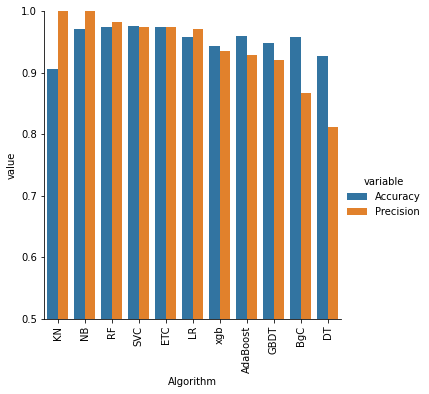

In [71]:
sns.catplot(x = 'Algorithm', y = 'value',
            hue = 'variable', data = performance_spam1, kind = 'bar', height = 5)
plt.ylim(0.5,1.0)
plt.xticks(rotation = 'vertical')
plt.show()

In [72]:
performance_spam1 = pd.DataFrame({'Algorithm':clfs.keys(), 'Accuracy_3000':accuracy_scores, 'Precision_3000':precision_scores}).sort_values('Precision_3000', ascending = False)

In [73]:
performance_spam.merge(performance_spam1, on = 'Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_3000,Precision_3000
0,KN,0.905222,1.000000,0.905222,1.000000
1,NB,0.970986,1.000000,0.970986,1.000000
2,RF,0.974855,0.982759,0.974855,0.982759
3,SVC,0.975822,0.974790,0.975822,0.974790
4,ETC,0.974855,0.974576,0.974855,0.974576
5,LR,0.958414,0.970297,0.958414,0.970297
6,xgb,0.943907,0.934783,0.943907,0.934783
7,AdaBoost,0.960348,0.929204,0.960348,0.929204
8,GBDT,0.947776,0.920000,0.947776,0.920000
9,BgC,0.957447,0.867188,0.957447,0.867188


## **5. File Pickling**

In [75]:
pickle.dump(tfidf,open('/content/drive/MyDrive/Capstone_Project_For_Data_Science/Email Spam Classifier/vectorizer.pkl','wb'))
pickle.dump(mnb,open('/content/drive/MyDrive/Capstone_Project_For_Data_Science/Email Spam Classifier/model.pkl','wb'))